In [17]:
import time
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from plot_keras_history import show_history, plot_history
from tqdm import tqdm

In [18]:
# Version of the libraries used
print('\n'.join(f'{m.__name__} - {m.__version__}'
                for m in globals().values()
                if getattr(m, '__version__', None)))

numpy - 1.26.3
pandas - 2.2.2
torch - 2.3.0+cu118


---

### **Emotions Labels :**
- 0 : Sadness
- 1 : Joy 
- 2 : Love
- 3 : Anger
- 4 : Fear
- 5 : Surprise

In [19]:
# Loading the dataset
df = pd.read_csv('../data/text.csv')

In [20]:
df.head(5)

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [21]:
df = df.drop("Unnamed: 0", axis=1)
df

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4
...,...,...
416804,i feel like telling these horny devils to find...,2
416805,i began to realize that when i was feeling agi...,3
416806,i feel very curious be why previous early dawn...,5
416807,i feel that becuase of the tyranical nature of...,3


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


In [23]:
df.isna().count()

text     416809
label    416809
dtype: int64

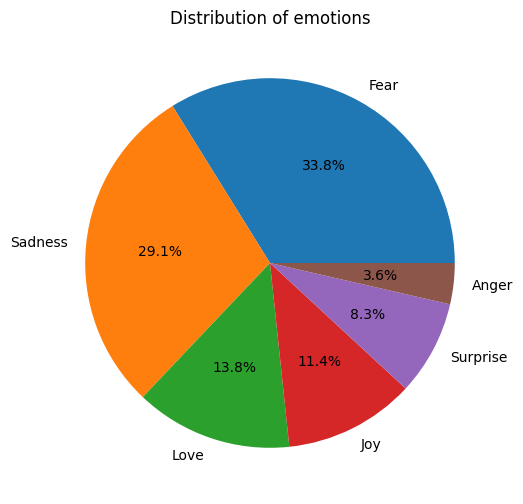

In [24]:
# Creating a dictionary to map numbers to emotion names
emotion_dict = {0: 'Sadness', 1: 'Joy', 2: 'Love', 3: 'Anger', 4: 'Fear', 5: 'Surprise'}

# Replacing numbers with emotion names in labels
labels = df['label'].replace(emotion_dict)

# Creating a pie chart to see the distribution of emotions in the dataset
plt.figure(figsize=(8,6))
plt.pie(labels.value_counts(), labels=labels.unique(), autopct='%1.1f%%')
plt.title('Distribution of emotions')
plt.show()

We see that the label column which is our target is unbalanced so we will use a weight redistribution to rebalance the importance of the labels in the dataset.

In [25]:
# Initialization of DataFrames for training, validation and testing
train_df = pd.DataFrame()
validation_df = pd.DataFrame()
test_df = pd.DataFrame()

# For each class, collect samples for training, for validation and for testing
for label in df['label'].unique():
    class_df = df[df['label'] == label]
    
    train_class_df = class_df.sample(n=5000, random_state=1)
    remaining_class_df = class_df.drop(train_class_df.index)
    
    validation_class_df = remaining_class_df.sample(n=1000, random_state=1)
    remaining_class_df = remaining_class_df.drop(validation_class_df.index)
    
    test_class_df = remaining_class_df.sample(n=1000, random_state=1)
    
    train_df = pd.concat([train_df, train_class_df])
    validation_df = pd.concat([validation_df, validation_class_df])
    test_df = pd.concat([test_df, test_class_df])

# Training data preparation
train_texts, train_labels = train_df['text'], train_df['label']

# Validation data preparation
validation_texts, validation_labels = validation_df['text'], validation_df['label']

# Test data preparation
test_texts, test_labels = test_df['text'], test_df['label']

# Print the number of samples per class for each dataset
print("Total number of samples per class:")
print("Training :")
print(train_df['label'].value_counts())
print("Validation :")
print(validation_df['label'].value_counts())
print("Test :")
print(test_df['label'].value_counts())

Total number of samples per class:
Training :
label
4    5000
0    5000
2    5000
1    5000
5    5000
3    5000
Name: count, dtype: int64
Validation :
label
4    1000
0    1000
2    1000
1    1000
5    1000
3    1000
Name: count, dtype: int64
Test :
label
4    1000
0    1000
2    1000
1    1000
5    1000
3    1000
Name: count, dtype: int64


As the smallest class has only 15,000 samples (3.6%) we can then randomly take 1,000 samples for each class to rebalance the dataset.

---

## **DistilBert**

In [26]:
# Loading the DistilBERT model
distil_bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distil_bert_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=6) # 6 classes of emotions

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
# Move the model to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
distil_bert_model = distil_bert_model.to(device)

In [28]:
train_encodings = distil_bert_tokenizer(train_texts.tolist(), truncation=True, padding=True, return_tensors='pt')
train_labels = torch.tensor(train_labels.tolist())
train_dataset = TensorDataset(train_encodings.input_ids, train_encodings.attention_mask, train_labels)

In [29]:
# Preparation of validation data
validation_encodings = distil_bert_tokenizer(validation_texts.tolist(), truncation=True, padding=True, return_tensors='pt')
validation_labels = torch.tensor(validation_labels.tolist())
validation_dataset = TensorDataset(validation_encodings.input_ids, validation_encodings.attention_mask, validation_labels)

In [30]:
# Preparation of test data
test_encodings = distil_bert_tokenizer(test_texts.tolist(), truncation=True, padding=True, return_tensors='pt')
test_labels = torch.tensor(test_labels.tolist())
test_dataset = TensorDataset(test_encodings.input_ids, test_encodings.attention_mask, test_labels)

In [31]:
# Definition of optimizer, loss function and metrics
lr = 5e-5
optimizer = torch.optim.Adam(distil_bert_model.parameters(), lr=lr)
loss = torch.nn.CrossEntropyLoss()
metrics = ['accuracy']

# Model compilation
epochs = 10
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [32]:
# Start the history & best precision
history = {
    'train_loss': [],
    'validation_loss': [],
    'validation_accuracy': []
}
best_acc = 0.0

# Define the regularization strength for penalty (avoid overfitting)
l2_lambda = 0.001

start_time = time.time()
for epoch in range(epochs):
    # Training
    distil_bert_model.train()
    total_loss = 0
    train_loader_progress = tqdm(train_loader, desc='Training')
    for batch in train_loader_progress:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch

        # Move data to GPU
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        outputs = distil_bert_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Add L2 regularization
        l2_norm = sum(p.pow(2.0).sum() for p in distil_bert_model.parameters())
        loss = loss + l2_lambda * l2_norm

        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_loader_progress.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    avg_train_loss = total_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)

    # Validation
    distil_bert_model.eval()
    total_val_loss = 0
    total_correct = 0
    total_samples = 0
    validation_loader_progress = tqdm(validation_loader, desc='Validating')
    for batch in validation_loader_progress:
        input_ids, attention_mask, labels = batch

        # Move data to GPU
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = distil_bert_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_val_loss += loss.item()

        # Accuracy calculation
        _, predictions = torch.max(outputs.logits, dim=1)
        correct = (predictions == labels).sum().item()
        total_correct += correct
        total_samples += labels.size(0)

    avg_val_loss = total_val_loss / len(validation_loader)
    val_accuracy = total_correct / total_samples
    history['validation_loss'].append(avg_val_loss)
    history['validation_accuracy'].append(val_accuracy)

    print(f"Epoch: {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Save the best weigths
    if val_accuracy > best_acc:
        best_acc = val_accuracy
        if not os.path.exists('../weigths'):
            os.makedirs('../weigths')
        torch.save(distil_bert_model.state_dict(), '../weigths/en_best_distilbert.pth')

end_time = time.time()

Validating: 100%|██████████| 188/188 [00:07<00:00, 23.59it/s]


Epoch: 1, Training Loss: 113.7287, Validation Loss: 0.1633, Validation Accuracy: 0.9473


Validating: 100%|██████████| 188/188 [00:07<00:00, 23.61it/s]


Epoch: 2, Training Loss: 51.2095, Validation Loss: 0.1624, Validation Accuracy: 0.9318


Validating: 100%|██████████| 188/188 [00:07<00:00, 23.58it/s]


Epoch: 3, Training Loss: 26.0952, Validation Loss: 0.1399, Validation Accuracy: 0.9467


Validating: 100%|██████████| 188/188 [00:07<00:00, 23.58it/s]


Epoch: 4, Training Loss: 15.3611, Validation Loss: 0.1397, Validation Accuracy: 0.9507


Validating: 100%|██████████| 188/188 [00:07<00:00, 23.57it/s]


Epoch: 5, Training Loss: 10.3747, Validation Loss: 0.1436, Validation Accuracy: 0.9480


Validating: 100%|██████████| 188/188 [00:07<00:00, 23.59it/s]


Epoch: 6, Training Loss: 7.7557, Validation Loss: 0.1415, Validation Accuracy: 0.9493


Validating: 100%|██████████| 188/188 [00:07<00:00, 23.56it/s]


Epoch: 7, Training Loss: 6.1833, Validation Loss: 0.1763, Validation Accuracy: 0.9403


Validating: 100%|██████████| 188/188 [00:07<00:00, 23.53it/s]


Epoch: 8, Training Loss: 5.1640, Validation Loss: 0.1528, Validation Accuracy: 0.9450


Validating: 100%|██████████| 188/188 [00:07<00:00, 23.62it/s]


Epoch: 9, Training Loss: 4.4230, Validation Loss: 0.1459, Validation Accuracy: 0.9460


Validating: 100%|██████████| 188/188 [00:07<00:00, 23.57it/s]

Epoch: 10, Training Loss: 3.8513, Validation Loss: 0.1633, Validation Accuracy: 0.9398


In [33]:
time_train_distilbert = end_time - start_time
print(f"Training Time --> {time_train_distilbert/60}")

Training Time --> 33.447391378879544


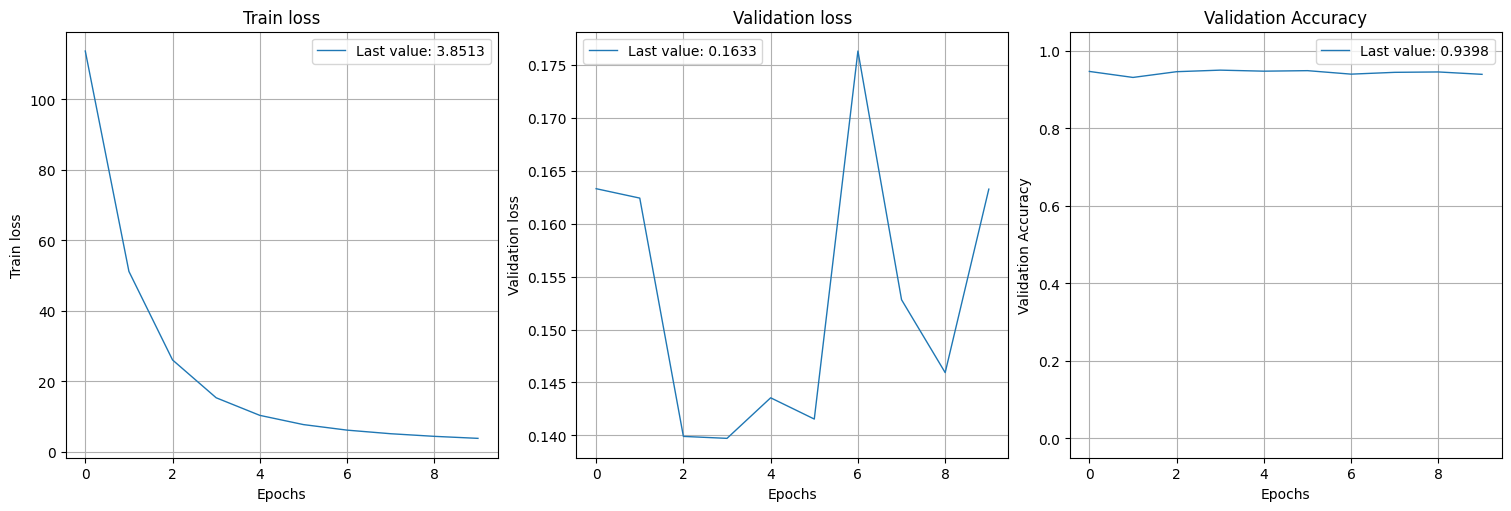

In [34]:
show_history(history)
plot_history(history, path="../history/en_distilbert_training.png")
plt.close()

---

In [35]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distil_bert_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=6)
distil_bert_model.load_state_dict(torch.load('../weigths/en_best_distilbert.pth'))

# Move the model to the GPU
distil_bert_model = distil_bert_model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
# Evaluation
distil_bert_model.eval()
total_test_loss = 0
total_correct = 0
total_samples = 0
test_loader_progress = tqdm(test_loader, desc='Testing')
for batch in test_loader_progress:
    input_ids, attention_mask, labels = batch

    # Move data to GPU
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = distil_bert_model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    total_test_loss += loss.item()

    # Accuracy calculation
    _, predictions = torch.max(outputs.logits, dim=1)
    correct = (predictions == labels).sum().item()
    total_correct += correct
    total_samples += labels.size(0)

avg_test_loss = total_test_loss / len(test_loader)
test_accuracy = total_correct / total_samples

print(f"Test Loss: {avg_test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}")

Testing: 100%|██████████| 188/188 [00:09<00:00, 20.57it/s]

Test Loss: 0.15, Test Accuracy: 0.94


---